# The Physical Layer as an Autoencoder


**First : change the runtime and hardware acceleration**

Runtime $\rightarrow$ Change runtime type

- Runtime type : Python 3
- Hardware accelerator : GPU

An autoencoder is a type of artificial neural network used to find a useful representation of some data $\mathbf{s}$ at an intermediate layer $\mathbf{x}$ through learning to reproduce the input at the output.

![autoencoder_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder_0.png?raw=true)



# Initialisation

In [1]:
# Install TensorFlow 2.0 on Google Collab if needed
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

In [2]:
#Set the GPU you want to use
num_GPU = 0

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

if num_GPU < len(gpus):
    tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[num_GPU], True)
    print('Only GPU number', num_GPU, 'used')

Tensorflow version:  2.0.0
Number of GPUs available : 4
Only GPU number 0 used


In [3]:
import os
import copy
import sys
import time
from datetime import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt  

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense, Lambda
from tensorflow.keras.regularizers import Regularizer

# Communicating messages

**An autoencoder-based communication systems aims to implement the transmitter, channel, and receiver as a single NN which reconstructs its input at its output**

The goal is to learn a modulation wich will be robust with respect to the perturbations introduced by the channel.

The channel is implemented as a "Noise Layer" without any learnable parameters, wich must be differentiable in order to perform SGD on the transmitter's parameters.

Examples:

- AWGN channel : $\mathbf{y} = \mathbf{x} + \mathbf{w}$

- Memoryless fading channel : $\mathbf{y} = h \mathbf{x} + \mathbf{n} $
- ...

![autoencoder](https://github.com/mgoutay/autoencodeur/blob/master/Images/autoencoder.png?raw=true)

First, let's transmit messages.

The first hyper-parameters to set are the total number of messages $M$ and the number of channel uses $N_c$

It can be seen that $M$ can also be seen as the modulation order. Indeed, sending one out of $M$ message is equivalent to sending $\log_2(M)$ bits.

We will implement the fowllowing network:
![model_0](https://github.com/mgoutay/autoencodeur/blob/master/Images/model_0.png?raw=true)

In [70]:
# Number of messages
M = 16

# Number of channel uses
ch_uses = 1

## Define the layers

In [108]:
class Transmitter(Layer):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Transmitter, self).__init__(**kwargs)
        self.M = M
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.emb_table = self.add_weight(shape=[self.M, 2*self.ch_uses], 
                                          initializer='random_normal',
                                          trainable=True)

    def call(self, messages):
        #Embedding
        self.x = tf.nn.embedding_lookup(self.emb_table, messages)
        
        # Normalize power per symbol to 1
        self.en_moy =tf.sqrt(2 * tf.reduce_mean(tf.square(self.emb_table)))
        self.x_norm = tf.divide(self.x, self.en_moy)
        
        #Real to complex
        self.x_cplx = tf.complex(self.x_norm[:, :int(self.ch_uses)], self.x_norm[:, int(self.ch_uses):])
            
        return self.x_cplx

In [109]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)

    def call(self, x, noise_stddev):
            
        self.noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        self.noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_stddev/tf.sqrt(2.)
        self.noise_cplx = tf.complex(self.noise_r, self.noise_i, name="noise")
        
        self.y = x + self.noise_cplx
            
        return self.y

In [110]:
class Receiver(Layer):

    def __init__(self, M, **kwargs):
        super(Receiver, self).__init__(**kwargs)
        self.M = M

    def build(self, input_shape):
        self.dense_0 = Dense(4*self.M, activation = tf.nn.relu)
        self.dense_1 = Dense(2*self.M, activation = tf.nn.relu)
        self.dense_2 = Dense(self.M, activation = None)

    def call(self, y):
        # Complex to Real
        self.y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
        
        #Dense layers
        self.d_0 = self.dense_0(self.y_real)
        self.d_1 = self.dense_1(self.d_0)
        self.d_2 = self.dense_2(self.d_1)
        
        #Softmax
        self.p_s = tf.nn.softmax(self.d_2)
        
        return self.p_s

## Define the model

In [111]:
class Autoencoder(Model):

    def __init__(self, M, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.M = M
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.tx = Transmitter(self.M, self.ch_uses)
        self.ch = Channel()
        self.rx = Receiver(self.M)
    
    def call(self, inputs):
        
        self.messages, self.snr = inputs
        self.noise_stddev = tf.sqrt( 2 / tf.pow(10., self.snr/10.0))
        
        self.x = self.tx(self.messages)
        self.y = self.ch(self.x, self.noise_stddev)
        self.p_s = self.rx(self.y)
        
        return self.p_s

## Instantiate the autoencoder

In [117]:
# SNR at training
training_snr = 15

# Instantiate an autoencoder
autoencoder = Autoencoder(M, ch_uses)

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

## Generate messages

In [118]:
def generate_ds_msgs(epoch_len, batch_size, M, training_snr):
    'Generate epoch_len batches of messages'
    
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    msg_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    snr_ds = tf.data.Dataset.from_tensor_slices(training_snr*tf.ones(shape=[epoch_len, batch_size, 1]))
    
    features_ds = tf.data.Dataset.zip((msg_ds, snr_ds))
    labels_ds = msg_ds
    return (features_ds, labels_ds)

## What about the loss function?

The loss function is the **sparse** (there is only one good class) **categorical cross-entropy**:

$$
\begin{align*}
L(\theta_T, \theta_R) &= \mathbb{E}_{m, y} - \log(\hat{\mathbf{p_{\theta_R}}}(m | y)), y \thicksim p(y|x)\\
&= H(m) - I_{\theta_T}(m; y) + \mathbb{E}_{s, y} [ D_{KL} (\mathbf{p_{\theta_R}}(m|y) || \hat{\mathbf{p_{\theta_R}}}(m|y)) ]\\
\end{align*}
$$

- $H(m)$ is the entropy  of the source

- $I_{\theta_T}(m; y) = I_{\theta_T}(m; y)$ is the mutual information between the sent and the received symbols

- $D_{KL} (\mathbf{p_{\theta_R}}(m|y) || \hat{\mathbf{p_{\theta_R}}}(m|y))$ is the KL-Divergence between the true and the predicted distributions

Hence, minimizing the sparse categorical cross-entropy loss both maximize the mutual information and minimize the KL-divergence between the true and the predicted distribution

In [125]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

## Train

In [126]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10

print('SER after each epoch:')

start_time = time.time()
for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_bits(epoch_size, batch_size, M, training_snr))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            p_s = autoencoder(features)

            # Loss value for this batch.
            loss_value =  loss_func(y_true=labels, y_pred=p_s)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    
    #Take the argmax of the probability distribution as the estimated message
    m_hat = tf.argmax(p_s, axis=1, output_type=tf.int32)
    
    ser = tf.reduce_sum(tf.clip_by_value(tf.abs(labels-m_hat), 0, 1))/(batch_size)
    print(ser.numpy(), end=', ')

print("\n\nExecution time : %s seconds" % (time.time() - start_time))

SER after each epoch:
0.101, 0.0967, 0.0908, 0.0943, 0.0981, 0.0947, 0.0902, 0.0927, 0.0942, 0.0881, 

Execution time : 17.324588775634766 seconds


## See learned constellation

In [127]:
x = autoencoder.x.numpy()

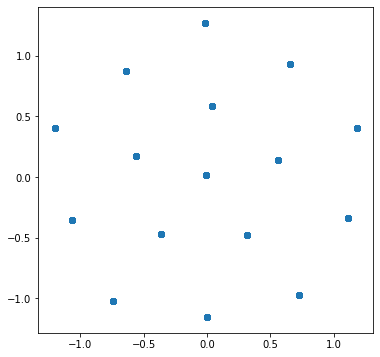

In [128]:
plt.figure(figsize=(6,6))
plt.scatter(np.real(x), np.imag(x))

# Communicating bits

# Define Layers

In [8]:
# Number of bits per symbols
K = 4
M = np.power(2, K)

# Number of channel uses
ch_uses = 1

In [3]:
class Encoder(Layer):

    def __init__(self, K, ch_uses=1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)
        self.ch_uses = ch_uses
        self.bin_conv = tf.convert_to_tensor(np.flip([np.power(2, i) for i in range(self.K)]).astype(np.int32)) # (8, 4, 2, 1)

    def build(self, input_shape):
        self.emb_table = self.add_weight(shape=[self.M, 2*self.ch_uses], 
                                          initializer='random_normal',
                                          trainable=True)

    def call(self, bits):
        self.bits_k = tf.reshape(bits, [-1, self.K])
        self.s = tf.reduce_sum(self.bits_k*tf.expand_dims(self.bin_conv,axis= 0), axis=1)
        self.x = tf.nn.embedding_lookup(self.emb_table, self.s)
        
        # Normalize power per symbol to 1
        self.en_moy =tf.sqrt(2 * tf.reduce_mean(tf.square(self.emb_table)))
        self.x_norm = tf.divide(self.x, self.en_moy)
        #Real to complex
        self.x_cplx = tf.complex(self.x_norm[:, :int(self.ch_uses)], self.x_norm[:, int(self.ch_uses):])
            
        return self.x_cplx

In [4]:
class Channel(Layer):

    def __init__(self, **kwargs):
        super(Channel, self).__init__(**kwargs)

    def call(self, x, noise_std):
            
        self.noise_r = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_std/tf.sqrt(2.)
        self.noise_i = tf.random.normal(shape = tf.shape(x), stddev = 1) * noise_std/tf.sqrt(2.)
        self.noise_cplx = tf.complex(self.noise_r, self.noise_i, name="noise")
        
        self.y = x + self.noise_cplx
            
        return self.y

In [5]:
class Decoder(Layer):

    def __init__(self, K, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)

    def build(self, input_shape):
        self.dense_0 = Dense(2*self.M, activation = tf.nn.relu)
        self.dense_1 = Dense(self.M, activation = tf.nn.relu)
        self.dense_2 = Dense(self.K, activation = None)

    def call(self, y):
        
        self.y_real = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=1)
        self.d_0 = self.dense_0(self.y_real)
        self.d_1 = self.dense_1(self.d_0)
        self.d_2 = self.dense_2(self.d_1)
        self.b_hat = tf.reshape(self.d_2, [-1])
        
        return self.b_hat

# Define the model

In [39]:
class Autoencoder(Model):

    def __init__(self, K, ch_uses=1, **kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.encoder = Encoder(self.K, self.ch_uses)
        self.channel = Channel()
        self.decoder = Decoder(self.K)
    
    def call(self, inputs):
        
        self.bits, self.snr = inputs
        
        self.noise_std = tf.sqrt( 2 / tf.pow(10., self.snr/10.0))
        
        self.x = self.encoder(self.bits)
        self.y = self.channel(self.x, self.noise_std)
        self.b_hat = self.decoder(self.y)
        
        return self.b_hat

In [40]:
def generate_ds_bits(epoch_len, batch_size, M, training_snr):
    'Generate epoch_len batches of messages'
    
    rand_msg = tf.random.uniform(shape=[epoch_len, batch_size], minval=0, maxval=M, dtype=tf.int32)
    msg_ds = tf.data.Dataset.from_tensor_slices(rand_msg)
    snr_ds = tf.data.Dataset.from_tensor_slices(training_snr*tf.ones(shape=[epoch_len, batch_size, 1]))
    
    features_ds = tf.data.Dataset.zip((msg_ds, snr_ds))
    labels_ds = msg_ds
    return (features_ds, labels_ds)

# Instantiate an  autoencoder

In [41]:
# SNR at training
training_snr = 15

# Instantiate an autoencoder
autoencoder = Autoencoder(M, ch_uses)

#Initialize optimizer
optimizer = tf.keras.optimizers.Adam()

## Train

BER after each epoch:


NameError: name 'Encoder' is not defined

# Train

In [9]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10

print('BER after each epoch:')

start_time = time.time()
for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_bits(epoch_size, batch_size, K, snr))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:

            # Forward pass.
            b_hat_log = autoencoder(features)

            # Loss value for this batch.
            loss_value =  loss_func(labels, b_hat_log, from_logits=True)

        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))

    b_hat = tf.cast(tf.sign(b_hat_log)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - labels))/(batch_size*K)
    print(ber.numpy(), end=', ')

print("\n\nExecution time : %s seconds" % (time.time() - start_time))

BER after each epoch:
0.20965, 0.1574, 0.115525, 0.091375, 0.06895, 0.053125, 0.04455, 0.040375, 0.039375, 0.035125, 

Execution time : 19.777037143707275 seconds


# See learned constellation

You can now directly see what's inside each class :

In [35]:
x = autoencoder.x.numpy()
print(x)

[[-0.7658981 -0.04487091j]
 [-0.26066825+0.7347326j ]
 [ 1.250048  -0.14272638j]
 ...
 [ 0.05869472+1.1574969j ]
 [-0.25172818-0.11254451j]
 [ 0.6742501 +0.2404414j ]]


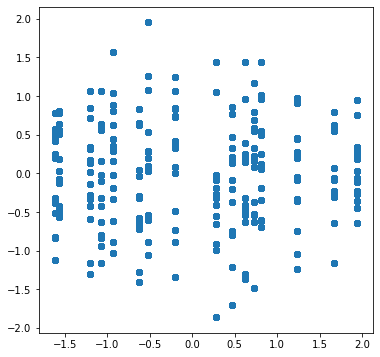

In [105]:
plt.figure(figsize=(6,6))
plt.scatter(np.real(x), np.imag(x))

In [8]:
def generate_ds_bits(epoch_len, batch_size, K, snr):
    'Generate a dataset for training'
    rand_bits = tf.random.uniform(shape=[epoch_len, batch_size*K], minval=0, maxval=2, dtype=tf.int32)
    bits_ds = tf.data.Dataset.from_tensor_slices(rand_bits)
    snr_ds = tf.data.Dataset.from_tensor_slices(snr*tf.ones(shape=[epoch_len, batch_size, 1]))
    
    features_ds = tf.data.Dataset.zip((bits_ds, snr_ds))
    labels_ds = tf.data.Dataset.from_tensor_slices(rand_bits)
    return (features_ds, labels_ds)

# Plot results

In [12]:
def generate_bits(batch_size, K):
    'Generate a batch for evaluating'
    rand_bits = tf.random.uniform(shape=[batch_size*K], minval=0, maxval=2, dtype=tf.int32)
    features = rand_bits
    labels = rand_bits
    return features, labels

In [13]:
snr_range = np.arange(-5, 26)
results=[]
bs_eval = 100000

for snr in snr_range:
    features, labels = generate_bits(bs_eval, K)
    b_hat_log = autoencoder([features, snr])
    b_hat = tf.cast(tf.sign(b_hat_log)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - labels))/(bs_eval*K)
    results.append(ber.numpy())
    print(snr, end=', ')

-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

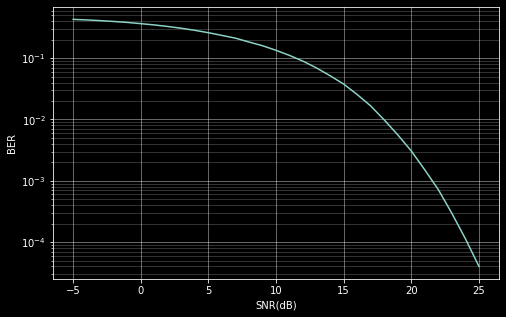

In [14]:
plt.figure(figsize=(8, 5))
plt.semilogy(snr_range, results)
plt.xlabel('SNR(dB)')
plt.ylabel('BER');
plt.grid(which='major', alpha=0.5)
plt.grid(which='minor', alpha=0.25)

# Tensorboard and @tf.function: create the model in a graph as in TF 1.x

Add the decorator @tf.function before the call function

In [28]:
class Autoencoder_graph(Model):

    def __init__(self, K, ch_uses=1, **kwargs):
        super(Autoencoder_graph, self).__init__(**kwargs)
        self.K = K
        self.M = int(2**self.K)
        self.ch_uses = ch_uses

    def build(self, input_shape):
        self.encoder = Encoder(self.K, self.ch_uses)
        self.channel = Channel()
        self.decoder = Decoder(self.K)
    
    @tf.function
    def call(self, inputs):
        
        self.bits, self.snr = inputs
        
        self.noise_std = tf.sqrt( 2 / tf.pow(10., self.snr/10.0))
        
        self.x = self.encoder(self.bits)
        self.y = self.channel(self.x, self.noise_std)
        self.b_hat = self.decoder(self.y)
        
        return self.b_hat

In [33]:
K = 4
ch_uses = 1
snr = 15

autoencoder_graph = Autoencoder_graph(K, ch_uses)

If the model is created in a graph, then we can use `tf.summary.trace_on()` to view the graph on Tensorboard :

In [30]:
# Create the writer for tensorboard
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

#Do only one batch
dataset = tf.data.Dataset.zip(generate_ds_bits(1, batch_size, K, snr))

#Trace the model
for step, (features, labels) in enumerate(dataset):
    tf.summary.trace_on(graph=True, profiler=True)
    b_hat_log = autoencoder_graph(features)
    with train_summary_writer.as_default():
        tf.summary.trace_export(
            name="my_func_trace",
            step=0,
            profiler_outdir=train_log_dir)

To visualise the Tensorboard session, open a terminal (File -> New -> Terminal), go to the current folder, and type

`tensorboard --logdir ./logs --bind_all`


Then go to http://127.0.0.1:10001 or http://127.0.0.1:10002 (or ...) on your browser

In [34]:
batch_size = 10000
epoch_size = 100
nb_epoch = 10

# Create the writer for tensorboard
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

#Initialise some metrics that we want to display in Tensorboard
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_ber = tf.keras.metrics.Mean('train_BER', dtype=tf.float32)
    
print('BER after each epoch:')
    
start_time = time.time()
for epoch in range(nb_epoch):
    
    # Create a dataset for each epoch
    dataset = tf.data.Dataset.zip(generate_ds_bits(epoch_size, batch_size, K, snr))

    # Iterate over the batches of the dataset.
    for step, (features, labels) in enumerate(dataset):
        # Open a GradientTape.
        with tf.GradientTape() as tape:
                        
            # Forward pass.
            b_hat_log = autoencoder_graph(features)

            # Loss value for this batch.
            loss_value =  loss_func(labels, b_hat_log, from_logits=True)
            
        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, autoencoder_graph.trainable_weights)

        # Update the weights of our linear layer.
        optimizer.apply_gradients(zip(gradients, autoencoder_graph.trainable_weights))

    b_hat = tf.cast(tf.sign(b_hat_log)/2+1, dtype=tf.int32)
    ber = tf.reduce_sum(tf.abs(b_hat - labels))/(batch_size*K)
    print(ber.numpy(), end=', ')
    
    #Write the metrics
    with train_summary_writer.as_default():
        train_loss(loss_value)
        train_ber(tf.constant(ber))
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('BER', train_ber.result(), step=epoch)
    #Reset the metrics
    train_loss.reset_states()
    train_ber.reset_states()
        
print("\n\nExecution time : %s seconds" % (time.time() - start_time))

BER after each epoch:
0.101525, 0.065575, 0.043425, 0.03695, 0.0365, 0.0344, 0.035325, 0.034, 0.0334, 0.03485, 

Execution time : 11.545795202255249 seconds


- Don't hesitate to refresh the Tensorboard page to see the new metrics
- The Tensorboard metrics can be called even when the model is not in a graph.
- The execution is (much) faster, but you loose acces to the variables inside the graph :

In [19]:
print(autoencoder_graph.x)

try:
    print(autoencoder_graph.x.numpy())
except:
    print('\n/!\ AttributeError: Tensor object has no attribute numpy')

Tensor("encoder_1/Complex:0", shape=(10000, 1), dtype=complex64)

/!\ AttributeError: Tensor object has no attribute numpy


# Building a model

If you decide to create graphs, you can also compile your model and use standard Keras function like fit() to train it.

In [20]:
# Instantiate an autoencoder
autoencoder_graph_2 = Autoencoder_graph(K, ch_uses)

#Initialise optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.binary_crossentropy

#Generate dataset
batch_size = 10000
epoch_size = 250
nb_epoch = 10
dataset = tf.data.Dataset.zip(generate_ds_bits(epoch_size, batch_size, K, snr))

#Compile and fit
autoencoder_graph_2.compile(optimizer, loss_func)
autoencoder_graph_2.fit(dataset, epochs=nb_epoch)

Epoch 1/10
250/250 [==============================] - 3s 10ms/step - loss: 1.0558
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.3954
Epoch 3/10
250/250 [==============================] - 2s 6ms/step - loss: 0.2591
Epoch 4/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1965
Epoch 5/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1965
Epoch 6/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1966
Epoch 7/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1615
Epoch 8/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1433
Epoch 9/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1273
Epoch 10/10
250/250 [==============================] - 2s 6ms/step - loss: 0.1252


In [21]:
autoencoder_graph_2.summary()

Model: "autoencoder_graph_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  32        
_________________________________________________________________
channel (Channel)            multiple                  0         
_________________________________________________________________
decoder (Decoder)            multiple                  692       
Total params: 724
Trainable params: 724
Non-trainable params: 0
_________________________________________________________________
